### Импортируем библиотеки
### WARNING: для отправки сообщений используется python-telegram-bot=13.7

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import telegram
import io

### Задаем значения переменным

In [2]:
token = BOT_TOKEN
bot = telegram.Bot(token=token)
chat_id = 96083455
group_chat_id = -802518328 # report group chat

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

### Загружаем из БД метрики ленты новостей посуточно за последние 7 дней

In [4]:
query = '''
SELECT toString(toDate(time)) as date,
        count(distinct user_id) as dau,
        countIf(action, action='view') as views,
        countIf(action, action='like') as likes,
        likes / views as ctr
FROM  simulator_20230320.feed_actions
where toDate(time) < today() and toDate(time) > yesterday() - 7
group by date
'''

In [5]:
df = ph.read_clickhouse(query, connection=connection)
df.head(10)

,date,dau,views,likes,ctr
0,2023-04-17,18699,770526,160940,0.208870
1,2023-04-18,19146,660300,142884,0.216393
2,2023-04-19,18585,617487,124494,0.201614
3,2023-04-20,18260,636338,128885,0.202542
4,2023-04-21,18269,608339,121381,0.199529
5,2023-04-22,18641,529200,107074,0.202332
6,2023-04-23,19026,513026,100781,0.196444


### Отправляем в чат Телеграм сообщение с метриками за предыдущий день

In [6]:
bot.sendMessage(chat_id=chat_id, text=f'Метрики за {df.iloc[6,0]}:\nDAU: {df.iloc[6,1]}\nПросмотры: {df.iloc[6,2]}\nЛайки: {df.iloc[6,3]}\nCTR: {df.iloc[6,4]:.2f}')

### Отправляем в чат Телеграм сообщение с графиками метрик за предыдущие 7 дней

Text(0.5, 1.0, 'CTR')

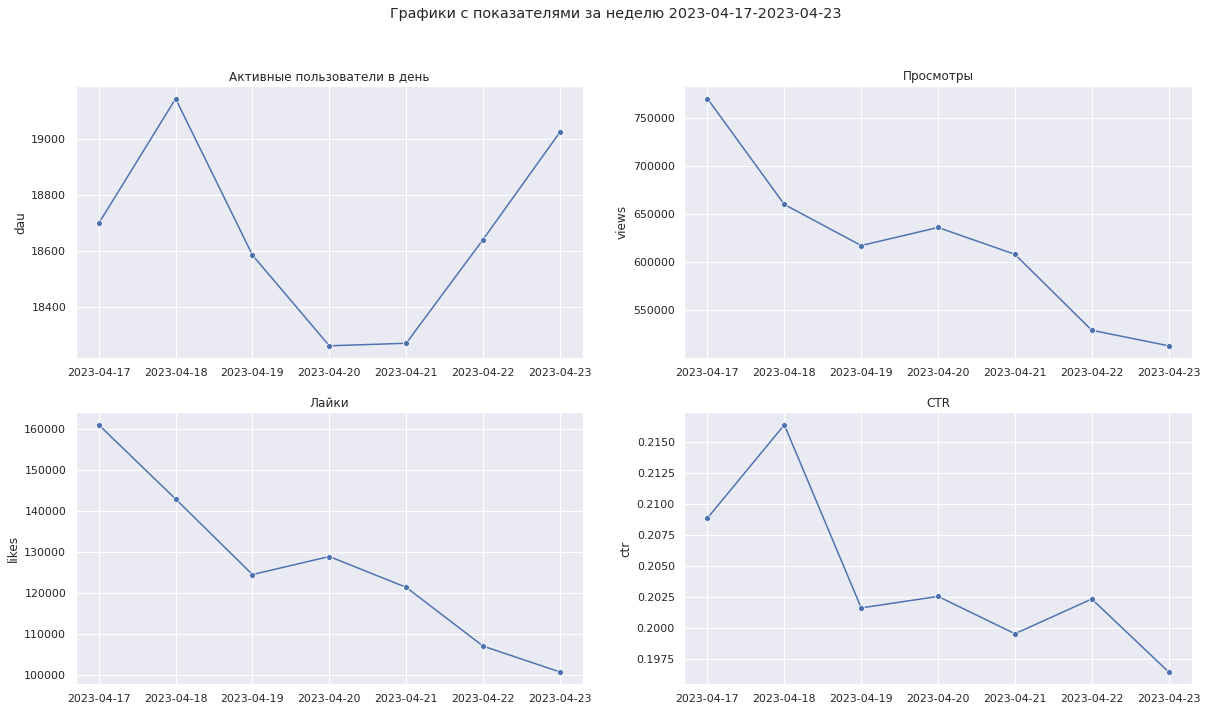

In [7]:
plt.rcParams['figure.figsize'] = [20, 11]
sns.set()

plot_object = io.BytesIO()

fig, axes = plt.subplots(2, 2)
fig.suptitle(f'Графики с показателями за неделю {df.iloc[0,0]}-{df.iloc[6,0]}')
sns.lineplot(data=df, x='date', y='dau', ax=axes[0,0], marker='o').set(xlabel=None)
axes[0,0].set_title('Активные пользователи в день')
sns.lineplot(data=df, x='date', y='views', ax=axes[0,1], marker='o').set(xlabel=None)
axes[0,1].set_title('Просмотры')
sns.lineplot(data=df, x='date', y='likes', ax=axes[1,0], marker='o').set(xlabel=None)
axes[1,0].set_title('Лайки')
sns.lineplot(data=df, x='date', y='ctr', ax=axes[1,1], marker='o').set(xlabel=None)
axes[1,1].set_title('CTR')
plt.savefig(plot_object)
plot_object.seek(0)
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object)

### Загружаем из БД метрики месенджера посуточно за последние 7 дней

In [8]:
query = '''
SELECT toString(toDate(time)) as date,
        count(user_id) as message_sent,
        count(distinct user_id) as message_senders,
        count(DISTINCT reciever_id ) as message_receivers
FROM  simulator_20230320.message_actions 
where toDate(time) < today() and toDate(time) > yesterday() - 7
group by date
order by date
'''

In [9]:
df = ph.read_clickhouse(query, connection=connection)
df.head()

,date,message_sent,message_senders,message_receivers
0,2023-04-17,12901,1959,1237
1,2023-04-18,12899,2937,1844
2,2023-04-19,12901,2097,1327
3,2023-04-20,12899,2019,1341
4,2023-04-21,12900,3007,1897


### Переворачиваем таблицу

In [10]:
df = df.rename(columns={'message_sent':'Отправлено сообщений','message_senders':'Отправители', 'message_receivers':'Получатели'})
melted = df.melt(id_vars=['date'], var_name="type", value_name="value")
melted

,date,type,value
0,2023-04-17,Отправлено сообщений,12901
1,2023-04-18,Отправлено сообщений,12899
2,2023-04-19,Отправлено сообщений,12901
3,2023-04-20,Отправлено сообщений,12899
4,2023-04-21,Отправлено сообщений,12900
5,2023-04-22,Отправлено сообщений,12901
6,2023-04-23,Отправлено сообщений,12892
7,2023-04-17,Отправители,1959
8,2023-04-18,Отправители,2937
9,2023-04-19,Отправители,2097


### Строим барплот на основании получившейся таблицы и отправляем его в чат ТГ

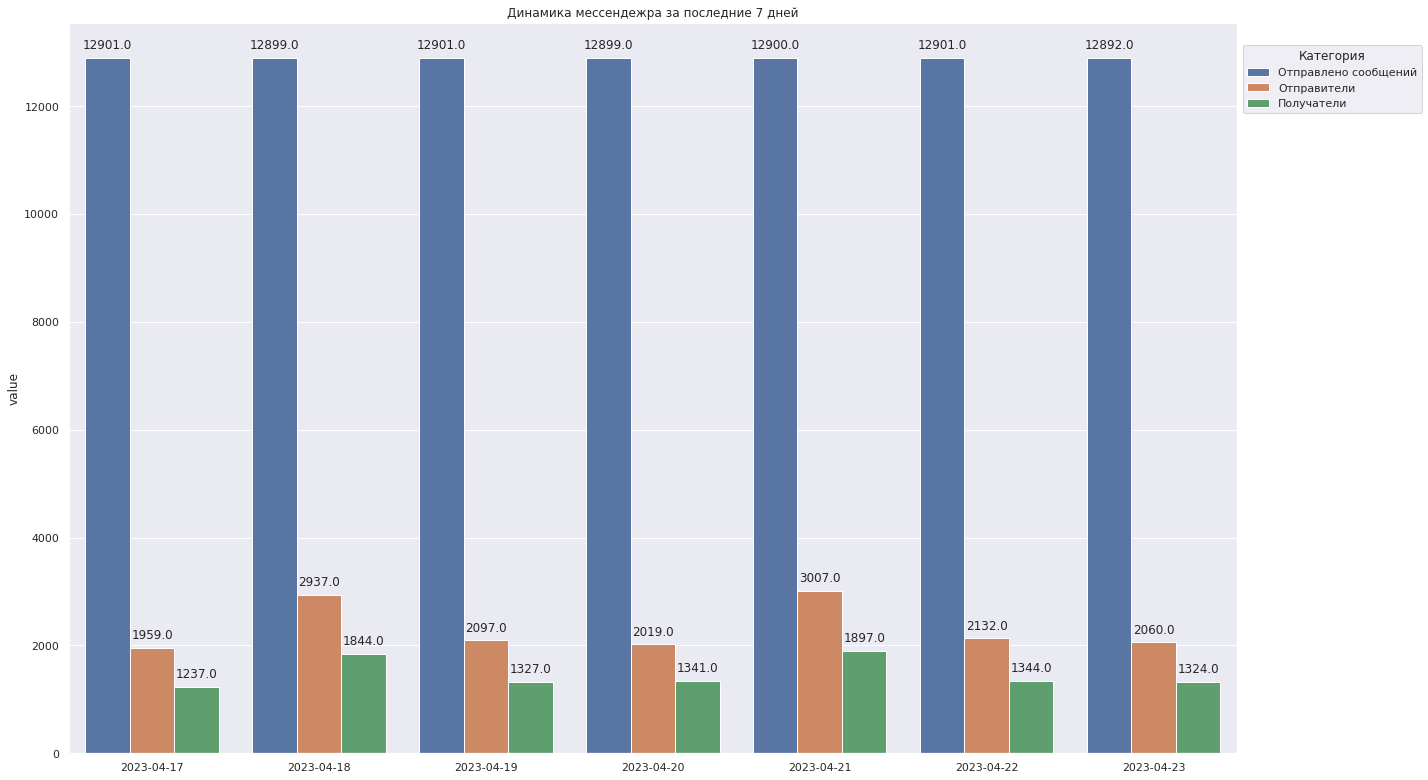

In [11]:
plt.rcParams['figure.figsize'] = [20, 11]
plt.rcParams["figure.autolayout"] = True

sns.set()
plot_object = io.BytesIO()
ax = sns.barplot(data=melted, x='date', y='value', hue='type')
ax.set(title='Динамика мессендежра за последние 7 дней')
# for i in ax.containers:
#     ax.bar_label(i,)
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    ax.text(x = p.get_x()+(p.get_width()/2), y = height+170, s = height, ha = 'center') # adding text to each bar
ax.set(xlabel=None)
plt.legend(title = 'Категория', bbox_to_anchor=(1.005, 0.97), loc='upper left', borderaxespad=0)
plt.savefig(plot_object)
plot_object.seek(0)
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object)

### Запрашиваем из БД данные под ретеншн

In [12]:
query = '''
SELECT start_day AS start_day,
       day AS day,
       count(user_id) AS users
FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM simulator_20230320.feed_actions
      GROUP BY user_id
      having start_day >= today() - 15 and start_day < today()
      ) t1
   JOIN
     (SELECT DISTINCT user_id,
                      toDate(time) AS day
      FROM simulator_20230320.feed_actions) t2 USING user_id
GROUP BY day, start_day
ORDER BY start_day, day
'''
df = ph.read_clickhouse(query, connection=connection)
df.head()

,start_day,day,users
0,2023-04-09,2023-04-09,1550
1,2023-04-09,2023-04-10,659
2,2023-04-09,2023-04-11,584
3,2023-04-09,2023-04-12,533
4,2023-04-09,2023-04-13,545


### Добавляем колонку с номером дня и создаем сводную таблицу

In [13]:
df['day_n'] = (df['day'] - df['start_day']).dt.days
df.start_day = df.start_day.astype(str)
pivot = df.pivot_table(index='start_day', columns='day_n', values='users')
pivot = pivot.divide(pivot[0], axis=0)
pivot.head()

day_n,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_day,,,,,,,,,,,,,,,,
2023-04-09,1.0,0.425161,0.376774,0.343871,0.351613,0.320645,0.327742,0.269032,0.271613,0.253548,0.226452,0.203871,0.186452,0.188387,0.168387,0.104516
2023-04-10,1.0,0.371501,0.337574,0.338422,0.337574,0.288380,0.270568,0.274809,0.229856,0.241730,0.195929,0.182358,0.179813,0.157761,0.115352,NaN
2023-04-11,1.0,0.411120,0.388374,0.347936,0.317607,0.308340,0.322662,0.286436,0.262848,0.218197,0.197978,0.181971,0.164280,0.125527,NaN,NaN
2023-04-12,1.0,0.301622,0.258378,0.229189,0.220541,0.231351,0.206486,0.185946,0.174054,0.143784,0.136216,0.130811,0.086486,NaN,NaN,NaN
2023-04-13,1.0,0.259777,0.196927,0.208101,0.192737,0.188547,0.206704,0.182961,0.148045,0.148045,0.121508,0.085196,NaN,NaN,NaN,NaN


### Рисуем тепловую карту получившейся сводной таблицы и отправляем в чат ТГ

Text(0.5, 1.0, 'Ретеншн за последние 14 дней')

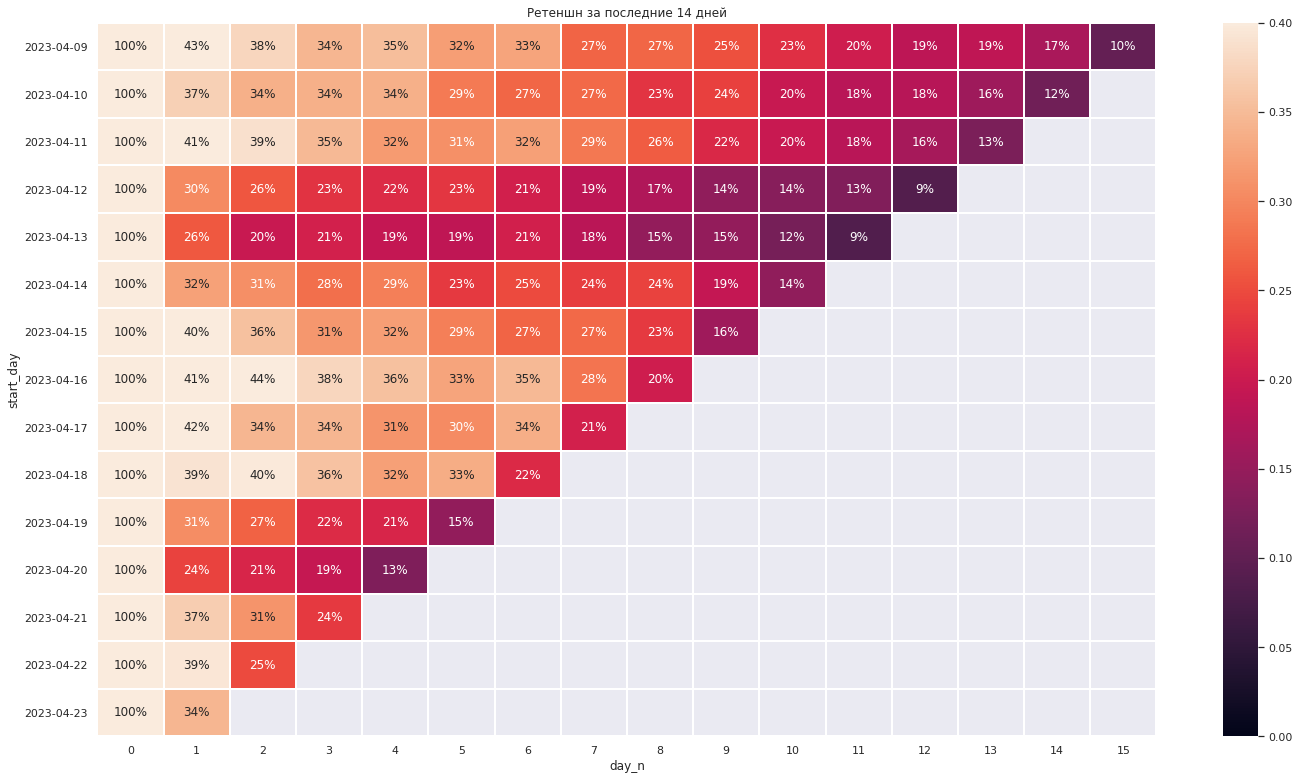

In [14]:
plt.rcParams['figure.figsize'] = [20, 11]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(pivot, linewidth=.01, annot=True, fmt='.0%', vmin=0, vmax=0.40)
plt.title('Ретеншн за последние 14 дней')
plot_object = io.BytesIO()
plt.savefig(plot_object)
plot_object.seek(0)
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object)

### Получаем из БД отношение пользователей ленты к пользователям мессенджера

In [15]:
query = '''
SELECT toString(day) as date, round(users1 / users2, 2) as users_ctr
FROM 
  (SELECT toDate(time) as day,
         count(distinct user_id) AS users1
  FROM simulator_20230320.feed_actions 
  WHERE toDate(time) < today() 
    and toDate(time) >= today() - 7
  GROUP BY day) as t1
JOIN
  (SELECT toDate(time) as day,
          count(distinct user_id) AS users2
  FROM simulator_20230320.message_actions 
  WHERE toDate(time) < today() 
    and toDate(time) >= today() - 7
  GROUP BY day) as t2 
  ON t1.day=t2.day
'''
df = ph.read_clickhouse(query, connection=connection)
df.head()

,date,users_ctr
0,2023-04-17,9.55
1,2023-04-18,6.52
2,2023-04-19,8.86
3,2023-04-20,9.04
4,2023-04-21,6.08


### Рисуем лайнчарт и отправляем его в ТГ

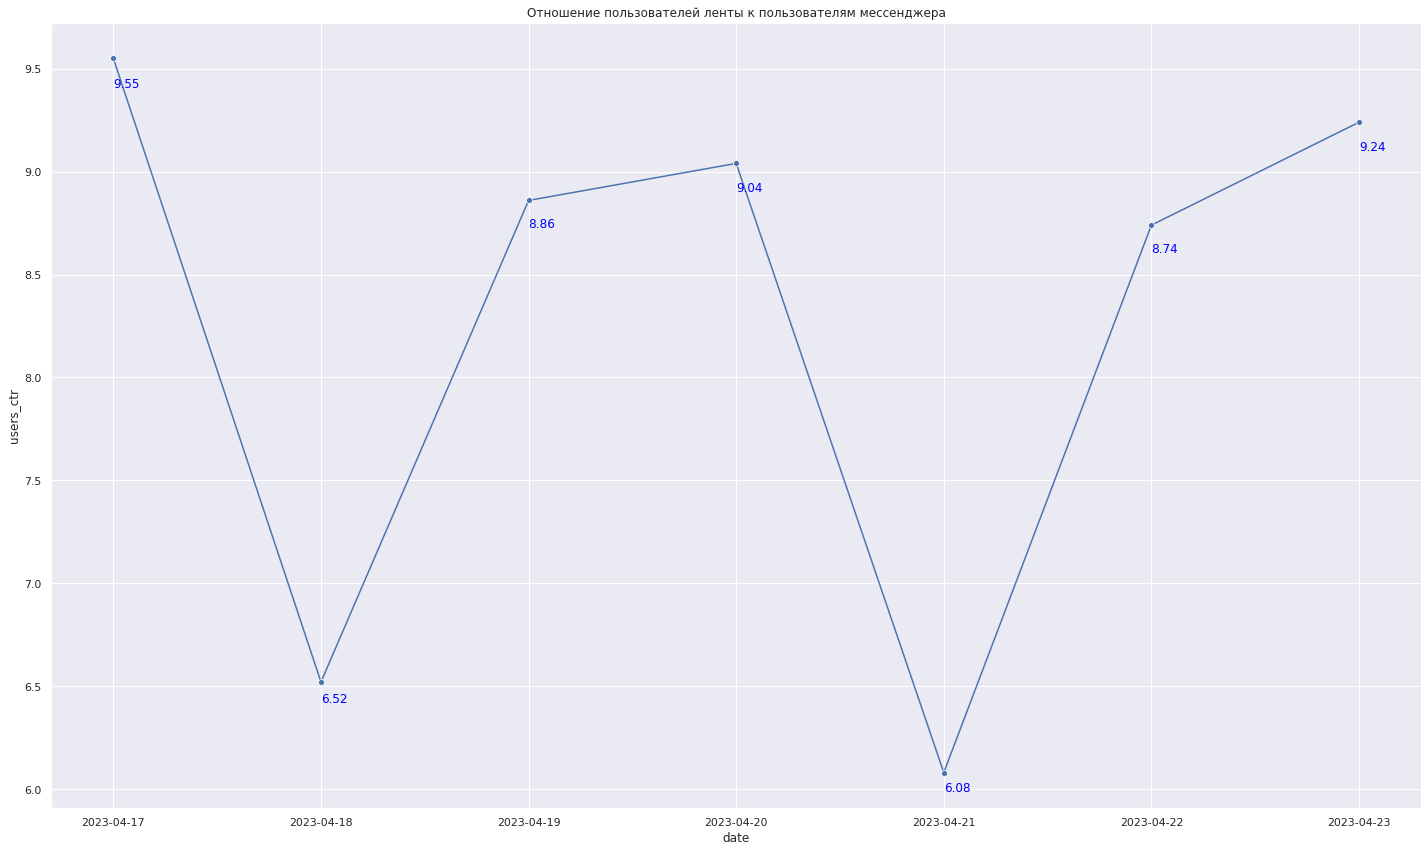

In [16]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams["figure.autolayout"] = True
sns.set()
plot_object = io.BytesIO()
ax = sns.lineplot(data=df, x='date', y='users_ctr', marker='o')
ax.set(title='Отношение пользователей ленты к пользователям мессенджера')
for x, y in zip(df['date'], df['users_ctr']):
    ax.text(x = x, y = 0.985*y, s = y, color = 'blue')
plt.savefig(plot_object)
plot_object.seek(0)
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object)